# Merton Jump Diffusion: Option pricing with Fourier transform

## Mathematics

The mathematics behind option pricing using the Fourier transform method are detailed in the notebook on Fourier transform pricing with the Black-Scholes model. Because the method is very similar with a Merton jump diffusion model, we will only explain the key differences here and you can refer to the other notebook for detailed mathematics. 

The main difference is the characteristic function of the process. The Merton jump diffusion process is obtained by adding a normal compound Poisson process to the geometric Brownian motion. The resulting characteristic function is given by

\begin{equation}
    \psi(\xi) = \exp \left[ i \xi \left(r - q - \frac{1}{2} \sigma^2 - \lambda \left(e^{i \xi \mu_J + \frac{1}{2} \xi^2 \sigma_J^2} - 1 \right) \right) \Delta t - \frac{1}{2} \xi^2 \sigma^2 \Delta t + \lambda \left(e^{i \xi \mu_J - \frac{1}{2} \xi^2 \sigma_J^2} - 1 \right) \Delta t \right]
\end{equation}

where $\sigma$ is the stock price volatility, $r$ is the risk-free interest rate, $q$ is the dividend rate, $\lambda$ is the rate of arrival of the jumps, $\mu_J$ is the mean of the jump sizes, $\sigma_J$ is the volatility of the jump sizes and $i$ is the imaginary unit such that $i = \sqrt{-1}$.

## Implementation

First, let's import some useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Let's implement a function which returns the damped payoff and its Fourier transform.

In [2]:
# Function for the Fourier transform of the payoff
def payoff(x, xi, alpha, K, L, U, C, call=1):
    
    # scale
    S = C*np.exp(x)   
    
    # payoff
    if call == 1: # call
        g = np.exp(alpha*x) * np.maximum(S - K, 0) * (S>=L).astype(int) * (S<=U).astype(int)
    else: # put
        g = np.exp(alpha*x) * np.maximum(K - S, 0) * (S>=L).astype(int) * (S<=U).astype(int)
        
    # Analitical Fourier transform of the payoff
    l = np.log(L/C) # lower log barrier
    k = np.log(K/C) # log strike
    u = np.log(U/C) # upper log barrier
    
    # Integration bounds
    if call == 1:
        a = max(l, k)
        b = u
    else:
        a = min(k, u)
        b = l
        
    xi_2 = alpha + 1j*xi
    
    # Fourier transform of damped payoff
    with np.errstate(divide='ignore', invalid='ignore'): # disable warning for when alpha = 0
        G = C*((np.exp(b * (1 + xi_2)) - np.exp(a * (1 + xi_2))) / (1 + xi_2) \
           - (np.exp(k + b*xi_2) - np.exp(k + a*xi_2)) / xi_2)
    
    # Eliminable discontinuities for xi = 0, otherwise 0/0 = NaN
    if alpha == 0:
        G[int(np.floor(len(G)/2))] = C*(np.exp(b)-np.exp(a)-np.exp(k)*(b-a))
    elif alpha == -1:
        G[int(np.floor(len(G)/2))] = C*(b-a+np.exp(k-b)-np.exp(k-a))
    
    return g, G, S

Now, let's define some parameters and compute the call and put prices.

In [3]:
# Market parameters
T = 1      # maturity
S0 = 1    # spot price
K = 1.1   # strike price
r = 0.05   # risk-free interest rate
q = 0.02   # dividend rate

# Model parameter
sigma = 0.4 # volatility

# Model parameters for the jump part
mu_j = -0.1
sigma_j = 0.15
lmbda = 0.5

# Risk-neutral measure
muRN = r-q-0.5*sigma**2 - lmbda*(np.exp(mu_j + 0.5*sigma_j**2) - 1) # drift

# Fourier parameters
xwidth = 6  # width of the support in real space
ngrid = 2**8 # number of grid points
alpha = -1 # damping factor for a call

# Grids in real and Fourier space
N = int(ngrid/2)
b = xwidth/2 # upper bound of the support in real space
dx = xwidth/ngrid
x = dx * np.linspace(-N, N-1, 2*N)
dxi = 2*np.pi/xwidth # Nyquist relation
xi = dxi * np.linspace(-N, N-1, 2*N)

# Characteristic function at time T
xia = xi + 1j*alpha # call
psi = 1j*muRN*xia - 0.5*(sigma*xia)**2 + lmbda*(np.exp(1j*mu_j*xia - 0.5*(sigma_j*xia)**2) - 1) # characteristic exponent
psi_c = np.exp(psi*T) # characteristic function

xia = xi - 1j*alpha # put
psi = 1j*muRN*xia - 0.5*(sigma*xia)**2 + lmbda*(np.exp(1j*mu_j*xia - 0.5*(sigma_j*xia)**2) - 1) # characteristic exponent
psi_p = np.exp(psi*T) # characteristic function

# Fourier transform of the payoff
U = S0 * np.exp(b)
L = S0 * np.exp(-b)
gc, Gc, S = payoff(x, xi, alpha, K, L, U, S0, 1)
gp, Gp, S = payoff(x, xi, -alpha, K, L, U, S0, 0)
    
# Discounted expected payoff computed with the Plancherel theorem    
c = np.exp(-r*T)*np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Gc*np.conj(psi_c)))))/xwidth        
Vc = interp1d(S, c, kind='slinear')(S0) # Call value
p = np.exp(-r*T)*np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Gp*np.conj(psi_p)))))/xwidth 
Vp = interp1d(S, p, kind='slinear')(S0) # Put value

print('The value of the call is ' + str(np.round(Vc, 5)) + '.')
print('The value of the put is  ' + str(np.round(Vp, 5)) + '.')

The value of the call is 0.13617.
The value of the put is  0.20232.


Comparing these option prices with those obtained in the Black-Scholes notebook with the same parameters, we see that Merton jump diffusion yields slightly higher prices. This is due to the increased volatility resulting from the jump component.

Because $V$ is a real number, taking its complex conjugate does not change and the integrand in Fourier space can also be written as $\hat{g}^*(\xi) \psi (\xi + i \alpha, T)$ (i.e. we take the complex conjugate of the payoff instead of the characteristic function).

In [4]:
# Discounted expected payoff computed with the Plancherel theorem    
c = np.exp(-r*T)*np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(np.conj(Gc)*psi_c))))/xwidth        
Vc = interp1d(S, c, kind='slinear')(S0) # Call value
p = np.exp(-r*T)*np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(np.conj(Gp)*psi_p))))/xwidth 
Vp = interp1d(S, p, kind='slinear')(S0) # Put value

print('The value of the call is ' + str(np.round(Vc, 5)) + '.')
print('The value of the put is  ' + str(np.round(Vp, 5)) + '.')

The value of the call is 0.13617.
The value of the put is  0.20232.


Also note that the integration in Fourier space is overengineered by taking the zero-frequency value of an FFT. We could obtain the same result using other integration techniques such as the trapezoidal integration rule.

In [5]:
# Discounted expected payoff computed with the Plancherel theorem    
Vc = np.exp(-r*T)*np.real(np.trapz(np.conj(Gc)*psi_c))/xwidth        
Vp = np.exp(-r*T)*np.real(np.trapz(np.conj(Gp)*psi_p))/xwidth 

print('The value of the call is ' + str(np.round(Vc, 5)) + '.')
print('The value of the put is  ' + str(np.round(Vp, 5)) + '.')

The value of the call is 0.13617.
The value of the put is  0.20232.


We can also compute the integral in log-price space by multiplying the undampened payoff by the one-time probability density function at maturity obtained with an inverse FFT of the characteristic function. 

In [6]:
# characteristic function
psi = 1j*muRN*xi - 0.5*(sigma*xi)**2 + lmbda*(np.exp(1j*mu_j*xi - 0.5*(sigma_j*xi)**2) - 1) # characteristic exponent
psi = np.exp(psi*T) # characteristic function

# PDF
f = np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(psi))))/xwidth

# Payoff
gc = np.maximum(S0*np.exp(x) - K, 0)
gp = np.maximum(K - S0*np.exp(x), 0)

# Integrate and discount to get option values
Vc = np.exp(-r*T)*np.trapz(gc*f*dx)
Vp = np.exp(-r*T)*np.trapz(gp*f*dx)

print('The value of the call is ' + str(np.round(Vc, 5)) + '.')
print('The value of the put is  ' + str(np.round(Vp, 5)) + '.')

The value of the call is 0.13614.
The value of the put is  0.20229.


Finally, let's plot the PDF obtained at the previous step.

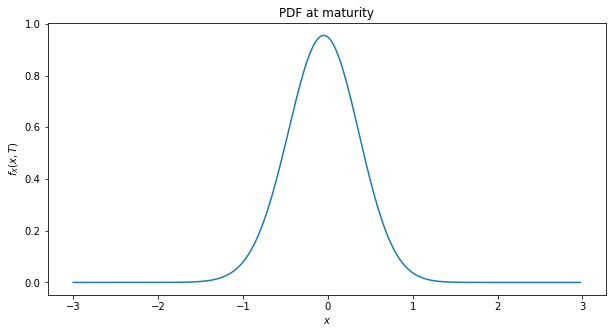

In [7]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(x, f)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f_X(x, T)$')
ax.set_title('PDF at maturity');